In [1]:
import warnings 
warnings.filterwarnings('ignore') # feel free to comment this out if you want to see warnings 

import csv 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, Flatten


from statsmodels.tools.eval_measures import rmse

import numpy as np
from tabulate import tabulate

Using TensorFlow backend.


In [2]:
sars = pd.read_csv('../data/sars_2003_complete_dataset_clean.csv')

In [3]:
sars.head(15)

,Date,Country,Cumulative number of case(s),Number of deaths,Number recovered
0,2003-03-17,Germany,1,0,0
1,2003-03-17,Canada,8,2,0
2,2003-03-17,Singapore,20,0,0
3,2003-03-17,"Hong Kong SAR, China",95,1,0
4,2003-03-17,Switzerland,2,0,0
5,2003-03-17,Thailand,1,0,0
6,2003-03-17,Viet Nam,40,1,0
7,2003-03-18,Germany,2,0,0
8,2003-03-18,Canada,8,2,0
9,2003-03-18,China,0,0,0


### Pre-processing
We want to isolate our data to find: Country, Date, Confirmed Cases

In [4]:
sars = sars[["Date", "Country", "Cumulative number of case(s)"]]

Here we want to start looking at data after the 2nd confirmed case. The reason why it's so low is because Italy has a faily low confirmed case

In [5]:
US = sars.loc[sars["Country"] == "United States"]
US = US.loc[US["Cumulative number of case(s)"] > 2] 
US = US.reset_index(drop=True)
US = US.rename(columns={"Cumulative number of case(s)":"Confirmed"})

china = sars.loc[sars["Country"] == "China"]
china = china.loc[china["Cumulative number of case(s)"] > 2] 
china = china.reset_index(drop=True)
china = china.rename(columns={"Cumulative number of case(s)":"Confirmed"})

italy = sars.loc[sars["Country"] == "Italy"]
italy = italy.loc[italy["Cumulative number of case(s)"] > 2] 
italy = italy.reset_index(drop=True)
italy = italy.rename(columns={"Cumulative number of case(s)":"Confirmed"})

In [6]:
US

,Date,Country,Confirmed
0,2003-03-19,United States,11
1,2003-03-20,United States,11
2,2003-03-21,United States,13
3,2003-03-22,United States,22
4,2003-03-24,United States,37
...,...,...,...
89,2003-07-07,United States,73
90,2003-07-08,United States,74
91,2003-07-09,United States,75
92,2003-07-10,United States,75


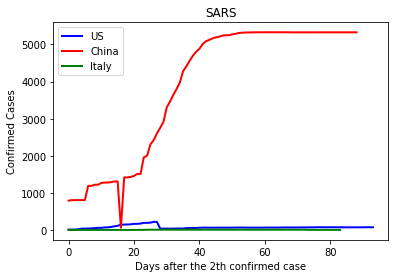

In [7]:
plt.plot(US.index, US['Confirmed'], 'b', linewidth = 2, label="US")
plt.plot(china.index, china['Confirmed'], 'r', linewidth = 2, label="China")
plt.plot(italy.index, italy['Confirmed'], 'g', linewidth = 2, label="Italy")
plt.title("SARS")
plt.xlabel("Days after the 2th confirmed case")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()

# Predict China

In [8]:
china = china[["Date", "Confirmed"]]

In [9]:
china.Date = pd.to_datetime(china.Date)

In [10]:
china = china.set_index("Date")

In [11]:
train_data = china[:len(china)-3]
test_data = china[len(china)-3:]

In [12]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [13]:
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [14]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [16]:
lstm_model.fit_generator(generator,epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
83/83 [==============================] - 1s 7ms/step - loss: 0.1360
Epoch 2/20
83/83 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 3/20
83/83 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 4/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 5/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 6/20
83/83 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 7/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 8/20
83/83 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 9/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 10/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 11/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/20
83/83 [==============================] - 0s 4ms/step - loss: 0.0021
E

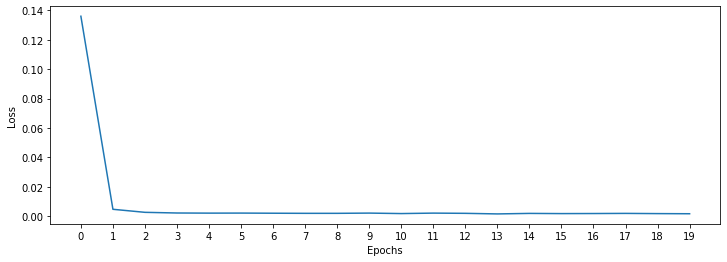

In [17]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [18]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [19]:
lstm_predictions_scaled

[array([1.0240514], dtype=float32),
 array([1.0290735], dtype=float32),
 array([1.0369458], dtype=float32)]

In [20]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[5455.67887044],
       [5482.13000226],
       [5523.59363317]])

In [21]:
test_data['LSTM_Predictions'] = lstm_predictions
test_data

,Confirmed,LSTM_Predictions
Date,,
2003-07-09,5327,5455.678870
2003-07-10,5327,5482.130002
2003-07-11,5327,5523.593633


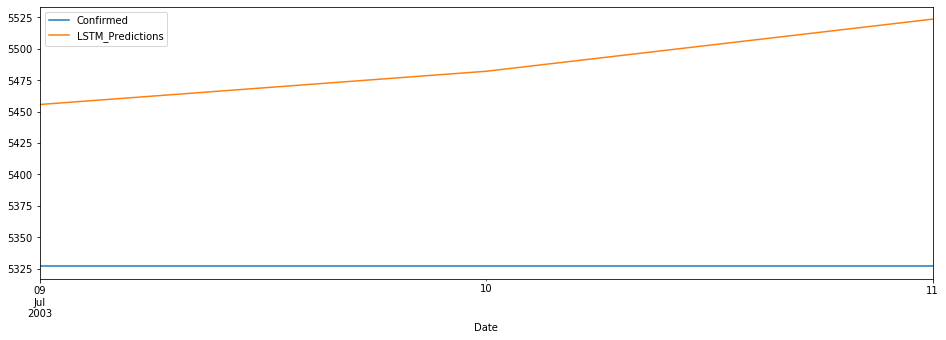

In [22]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [23]:
lstm_rmse_error_china = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_china = lstm_rmse_error_china**2
mean_value = china['Confirmed'].mean()

print(f'MSE Error: {lstm_mse_error_china}\nRMSE Error: {lstm_rmse_error_china}\nMean: {mean_value}')

MSE Error: 26424.20863458368
RMSE Error: 162.5552479453791
Mean: 3854.9775280898875


# Predict US

In [24]:
US = US[["Date", "Confirmed"]]
US.Date = pd.to_datetime(US.Date)
US = US.set_index("Date")
train_data = US[:len(US)-3]
test_data = US[len(US)-3:]

In [25]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [26]:
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [27]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [28]:
lstm_model.fit_generator(generator,epochs=20, verbose=0)

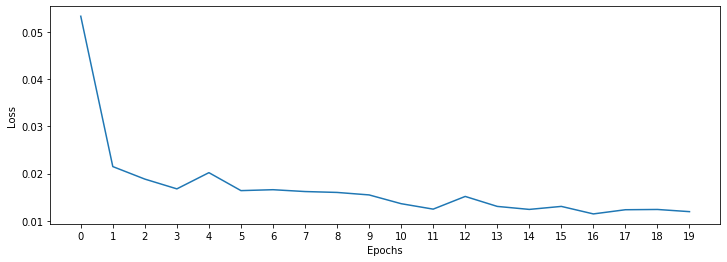

In [29]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [30]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
print(lstm_predictions)
test_data['LSTM_Predictions'] = lstm_predictions
print(test_data)

[[80.83225834]
 [84.49884874]
 [88.93014106]]
            Confirmed  LSTM_Predictions
Date                                   
2003-07-09         75         80.832258
2003-07-10         75         84.498849
2003-07-11         75         88.930141


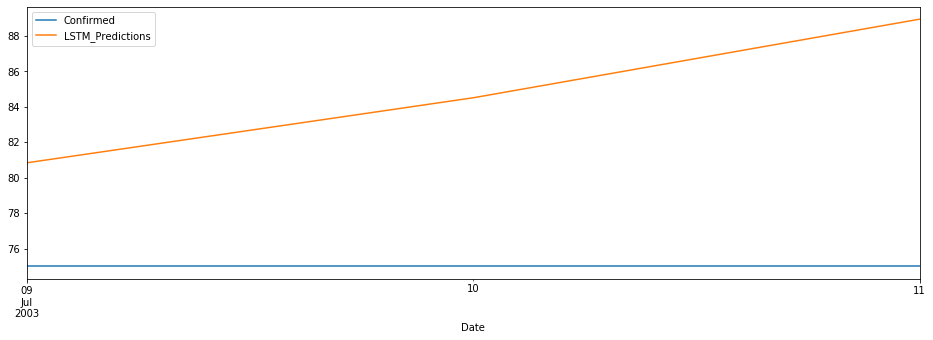

In [31]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [32]:
lstm_rmse_error_us = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_us = lstm_rmse_error_us**2
mean_value = US['Confirmed'].mean()

print(f'MSE Error: {lstm_mse_error_us}\nRMSE Error: {lstm_rmse_error_us}\nMean: {mean_value}')

MSE Error: 106.09739823232988
RMSE Error: 10.300359131230808
Mean: 76.65957446808511


---

## Italy

In [33]:
italy = italy[["Date", "Confirmed"]]
italy.Date = pd.to_datetime(italy.Date)
italy= italy.set_index("Date")

train_data = italy[:len(italy)-3]
test_data = italy[len(italy)-3:]

In [34]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [35]:
n_input = 3
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [36]:
lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

In [37]:
lstm_model.fit_generator(generator,epochs=20, verbose=0)

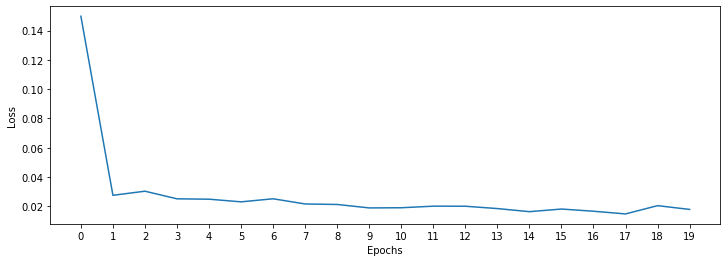

In [38]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [39]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

    
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
print(lstm_predictions)
test_data['LSTM_Predictions'] = lstm_predictions
print(test_data)
test_data

[[4.39904988]
 [4.63670343]
 [4.9870314 ]]
            Confirmed  LSTM_Predictions
Date                                   
2003-07-09          4          4.399050
2003-07-10          4          4.636703
2003-07-11          4          4.987031


,Confirmed,LSTM_Predictions
Date,,
2003-07-09,4,4.399050
2003-07-10,4,4.636703
2003-07-11,4,4.987031


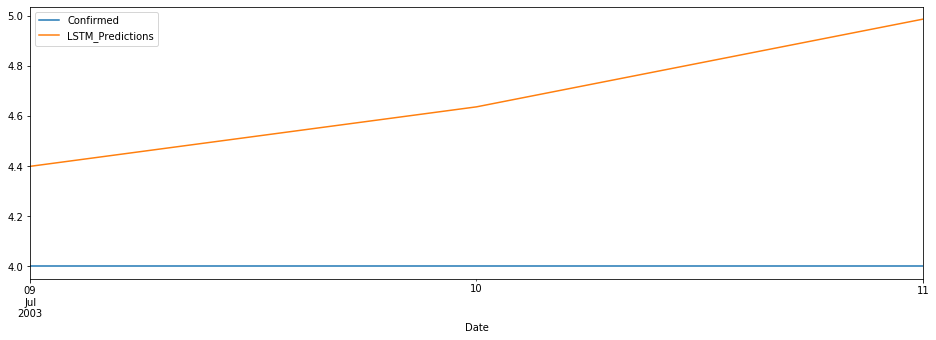

In [40]:
test_data['Confirmed'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [41]:
lstm_rmse_error_italy = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_italy = lstm_rmse_error_italy**2
mean_value = italy['Confirmed'].mean()

print(f'MSE Error: {lstm_mse_error_italy}\nRMSE Error: {lstm_rmse_error_italy}\nMean: {mean_value}')

MSE Error: 0.5129543500117465
RMSE Error: 0.7162083146764958
Mean: 6.690476190476191


In [42]:
print(tabulate([
    ['China LSTM Errors', lstm_mse_error_china, lstm_rmse_error_china], 
    ['US LSTM Errors', lstm_mse_error_us, lstm_rmse_error_us],
    ['Italy LSTM Errors', lstm_mse_error_italy, lstm_rmse_error_italy]], 
    
    headers=['Model', 'MSE', "RMSE", "Mean"]))




Model                       MSE        RMSE
-----------------  ------------  ----------
China LSTM Errors  26424.2       162.555
US LSTM Errors       106.097      10.3004
Italy LSTM Errors      0.512954    0.716208
